# PREDICT SALES OF THE ROSSMAN STORES

This project aims to predict the sales of the Rossman Stores for next 6 weeks.

# 0 - IMPORTS

In [23]:
import datetime
import inflection
import math

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt

from IPython.display       import Image

## 0.1 - Helper functions

## 0.2 - Loading data

In [2]:
# dataset
df_sales = pd.read_csv('dataset/train.csv', low_memory=False)
df_stores = pd.read_csv('dataset/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales, df_stores, how='left', on='Store')

# 1 - DATA DESCRIPTION

In [3]:
df1 = df_raw.copy()

## 1.1 - Rename columns

In [4]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'Id', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename columns
df1.columns = cols_new

## 1.2 - Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1001599
Number of columns: 19


## 1.3 - Data types

In [6]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
id                                int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
id                                       int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
id                                   0
store_type                           0
assortment                           0
competition_distance              2600
competition_open_since_month    318392
competition_open_since_year     318392
promo2                               0
promo2_since_week               500415
promo2_since_year               500415
promo_interval                  500415
dtype: int64

## 1.5 - Fillout NA

In [9]:
# competition distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1[['competition_open_since_month', 'date']].apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else 
                                                                                                    x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1[['competition_open_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else
                                                                                                  x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1[['promo2_since_week', 'date']].apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else 
                                                                              x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1[['promo2_since_year', 'date']].apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else
                                                                              x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval']==0 else
                                                                       1 if x['month_map'] in x['promo_interval'].split(',') else
                                                                       0, axis=1)

In [10]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
id                              0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 - Change data types

In [11]:
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 - Descriptive statistics

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numerical attributes

In [13]:
# Central Tendency - mean and median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.436424,558.0,321.909047,-0.000970,-1.200532
1,day_of_week,1.0,7.0,6.0,3.998315,4.0,1.997349,0.001618,-1.246824
2,sales,0.0,41551.0,41551.0,5770.573039,5741.0,3852.565888,0.643199,1.780100
3,customers,0.0,7388.0,7388.0,633.302988,610.0,464.942753,1.596438,7.073761
4,open,0.0,1.0,1.0,0.829645,1.0,0.375944,-1.753697,1.075454
5,promo,0.0,1.0,1.0,0.381894,0.0,0.485851,0.486181,-1.763631
6,school_holiday,0.0,1.0,1.0,0.173460,0.0,0.378644,1.724790,0.974903
7,id,0.0,1017207.0,1017207.0,508518.856749,508810.0,293464.542300,-0.000361,-1.199537
8,competition_distance,20.0,200000.0,199980.0,5935.551264,2330.0,12545.981696,10.241280,147.787195
9,competition_open_since_month,1.0,12.0,11.0,6.781137,7.0,3.319975,-0.039549,-1.241021


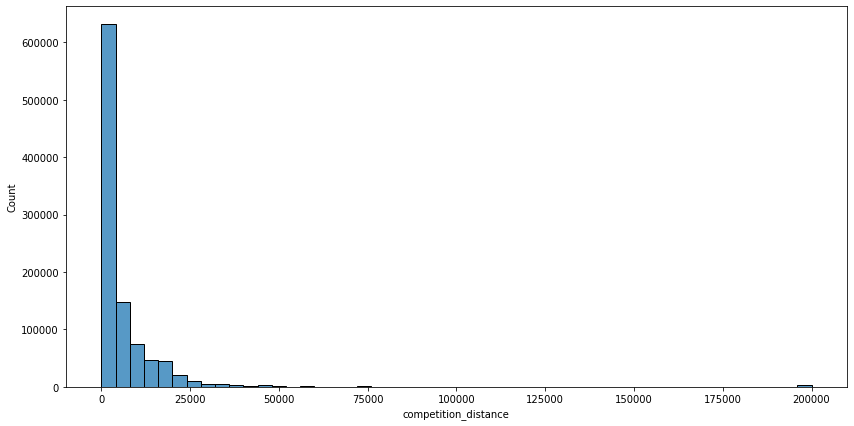

In [14]:
plt.figure(figsize=(14,7)) 
sns.histplot(df1['competition_distance'], kde=False, bins=50);

### 1.7.2 - Categorical attributes

In [15]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

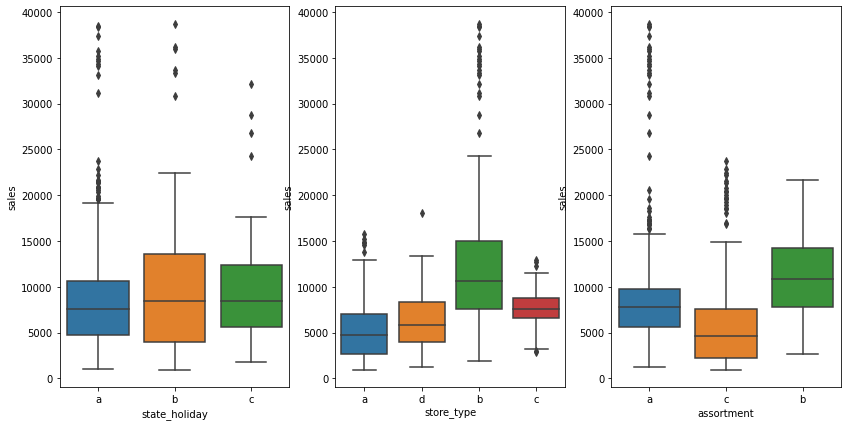

In [16]:
aux = df1[(df1['state_holiday']!='0') & (df1['sales']>0)]

plt.figure(figsize=(14,7)) 
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2 - FEATURE ENGINEERING

In [26]:
df2 = df1.copy()

## 2.1 - Mind map hypotheses

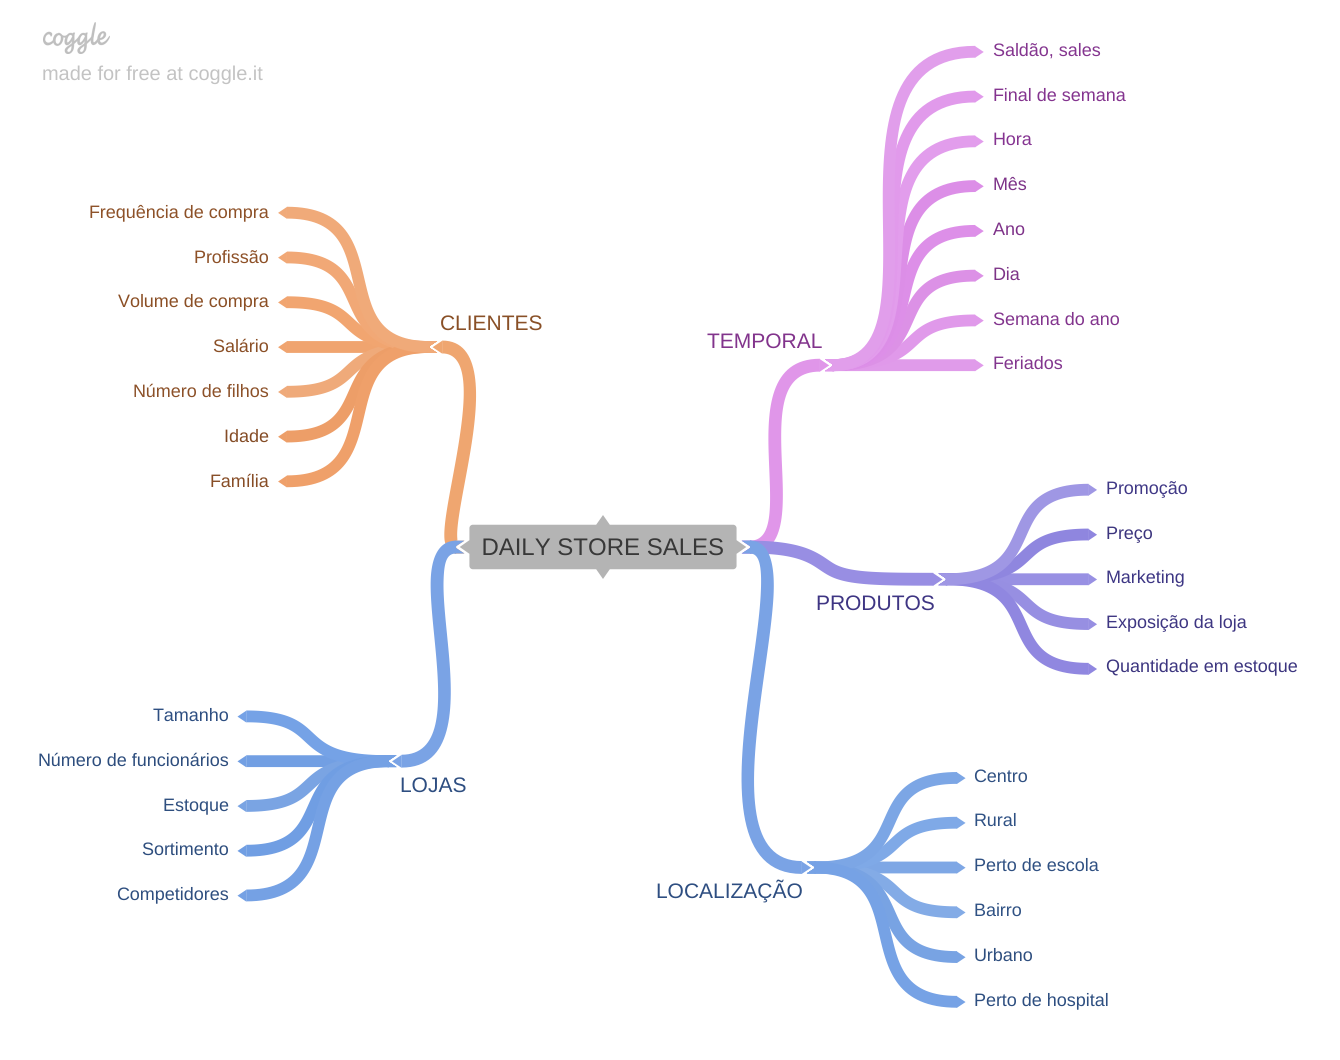

In [18]:
Image('img/DAILY_STORE_SALES.png')

## 2.2 - Creation of hypotheses

### 2.2.1 - Store hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with greater inventory capacity should sell more.

**3.** Larger stores should sell more.

**4.** Stores with greater assortment should sell more.

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer competitors should sell more.

### 2.2.2 - Product hypotheses

**1.** Stores that invest more in Marketing should sell more.

**2.** Stores with more product exposure should sell more.

**3.** Stores with lower priced products should sell more.

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with longer active promotions should sell more.

**7.** Stores with more days of promotion should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 - Time hypotheses

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 - Selected hypothses

**1.** Stores with larger assortments should sell more.

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with longer active promotions should sell more.

**5.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

**8.** Stores open during the Christmas holiday should sell more.

**9.** Stores should sell more over the years.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more after the 10th of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

## 2.4 - Feature engineering

In [27]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week_of_year
df2['week_of_year']= df2['date'].dt.isocalendar().week

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')